https://langchain-ai.github.io/langgraph/tutorials/introduction/

## Part 1: Build a Basic Chatbot¶
 

In [10]:
# Define the graph

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [11]:
# Add a chatbot node

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

# Add an entry point
graph_builder.add_edge(START, "chatbot")

# Add a finish point
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()

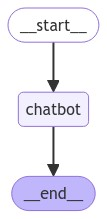

In [12]:
# Visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
# run the chatbot
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        print('*********Example event: ', event)
        for value in event.values():
            print('*********Example value: ', value)
            print("Assistant:", value["messages"][-1].content)

*********Example event:  {'chatbot': {'messages': [AIMessage(content='Donald Trump was not shot. He served as the 45th President of the United States from 2017 to 2021.', response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 10, 'total_tokens': 37}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0106de22-efd9-460e-92bc-64d53372c244-0', usage_metadata={'input_tokens': 10, 'output_tokens': 27, 'total_tokens': 37})]}}
*********Example value:  {'messages': [AIMessage(content='Donald Trump was not shot. He served as the 45th President of the United States from 2017 to 2021.', response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 10, 'total_tokens': 37}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0106de22-efd9-460e-92bc-64d53372c244-0', usage_metadata={'input_tokens': 10, 'output_tokens': 27, 'total_tokens'

## Part 2: Enhancing the Chatbot with Tools¶


In [14]:
# Create a Tavily search tool

from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's the rules to 8 ball pool")

[{'url': 'https://upatour.com/8-ball-rules/',
  'content': '8-Ball is played with a cue ball and fifteen object balls, numbered 1 through 15. Balls 1-7 are solid colors and commonly referred to as "low balls", and balls 9-15 are striped and commonly referred to as "high balls.". One player must pocket balls of solid colors, while the other player must pocket the striped balls.'},
 {'url': 'https://www.rulesofsport.com/sports/pool.html',
  'content': 'Winning the Game. 8 Ball pool is won when one of the following occurs: A player pots all of their designated balls and then legally pockets the 8 ball into their nominated pocket. The opposing player illegally pots the 8 ball before clearing their own set of balls. The 8 ball is knocked of the table by the opposition.'}]

In [15]:
# Define the graph again, except add bind_tools which lets the LLM know the correct JSON format to use if it wants to use our search engine.
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [16]:
# Implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers. We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [17]:
# Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state.

from typing import Literal

# check for tool_calls in the chatbot's output. Later, we will replace this with the prebuilt tools_condition to be more concise
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

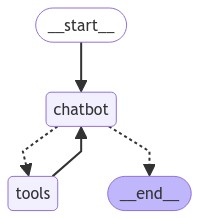

In [18]:
# Visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
# run chatbot
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: Hello Bob! How can I assist you today?
Assistant: I'm sorry, but I don't have access to your personal information, including your name. If there's anything else you'd like to know or discuss, feel free to ask!
Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Goodbye!


## Part 3: Adding Memory to the Chatbot¶


In [21]:
from langgraph.checkpoint.sqlite import SqliteSaver  # Or could use MemorySaver

memory = SqliteSaver.from_conn_string(
    ":memory:"
)  # Notice that we've specified :memory as the Sqlite DB path. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to connect to your own DB and/or use one of the other checkpointer classes.

In [23]:
# Next define the graph. Now that you've already built your own BasicToolNode, we'll replace it with LangGraph's prebuilt ToolNode and tools_condition, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool]) # new
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # new
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)

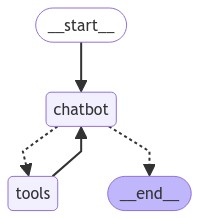

In [24]:
# Visualize. The same as before

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
# Now you can interact with your bot! 

# First, pick a thread to use as the key for this conversation.
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [26]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will. How can I help you today?


In [29]:
# To inspect a graph's state
snapshot = graph.get_state(config)
snapshot


StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='3314024c-4856-4611-a3ee-477da15f980c'), AIMessage(content='Hello Will! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 89, 'total_tokens': 100}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-a1d9cc52-0f2d-4127-94e1-93ed4a160320-0', usage_metadata={'input_tokens': 89, 'output_tokens': 11, 'total_tokens': 100}), HumanMessage(content='Remember my name?', id='389bb1eb-ebb6-4fa1-90d2-71ae28dcf089'), AIMessage(content='Yes, I remember your name, Will. How can I help you today?', response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 111, 'total_tokens': 128}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c10c9788-aaaf-4f2e-935d-7b23d786bed8-0', usage_metadata={'input_tokens': 111, 'outp

## Part 4: Human-in-the-loop¶


### Create a local retriever

In [32]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import (
    FAISS,
)  # This is Facebook AI's Similarity Search vector store
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = OpenAIEmbeddings()



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [33]:
# Skip this if you already have a faiss_index folder
loader = WebBaseLoader("https://en.wikipedia.org/wiki/Cancer")
docs = loader.load()
documents = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
).split_documents(docs)
vector = FAISS.from_documents(
    documents, embeddings
)  # This is in-memory. Have to do vector.save_local() to save to a faiss_index folder
vector.save_local("faiss_index")

In [34]:
# If you have the faiss_index folder (the vector store) already, just load it
vector = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)  # This is how you load it back
retriever = vector.as_retriever()
retriever.invoke("How many people die of cancer?")

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/Cancer', 'title': 'Cancer - Wikipedia', 'language': 'en'}, page_content='In 2008, approximately 12.7\xa0million cancers were diagnosed (excluding non-melanoma skin cancers and other non-invasive cancers)[25] and in 2010 nearly 7.98\xa0million people died.[212] Cancers account for approximately 16% of deaths. The most common as of 2018[update] are lung cancer (1.76\xa0million deaths), colorectal cancer (860,000) stomach cancer (780,000), liver cancer (780,000), and breast cancer (620,000).[2] This makes invasive cancer the leading cause of death in the developed world and the second leading in the developing world.[25] Over half of cases occur in the developing world.[25]'),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/Cancer', 'title': 'Cancer - Wikipedia', 'language': 'en'}, page_content='In 2015, about 90.5\xa0million people worldwide had cancer.[19] In 2019, annual cancer cases grew by 23.6\xa0million peopl

### Turn retriever into a tool

In [36]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "cancer_search",
    "Search for information about cancer based on wikipedia page. For any questions about cancer, you must use this tool!",
)
retriever_tool

Tool(name='cancer_search', description='Search for information about cancer based on wikipedia page. For any questions about cancer, you must use this tool!', args_schema=<class 'langchain_core.tools.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000016011F2B6A0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001603A9944D0>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'), coroutine=functools.partial(<function _aget_relevant_documents at 0x0000016011F2B880>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001603A9944D0>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'))

In [55]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated
from langchain_openai import ChatOpenAI

memory = SqliteSaver.from_conn_string(":memory:")


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool, retriever_tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool, retriever_tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"], # new
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [63]:
# run the chatbot
# user_input = "latest celebrity that was diagnosed with cancer?"
user_input = "deadliest type of cancer?"
config = {"configurable": {"thread_id": "2"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Joe. How can I assist you today, Joe?


In [66]:
snapshot = graph.get_state(config)
snapshot.next # the next node

()

In [58]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'cancer_search',
  'args': {'query': 'deadliest type of cancer'},
  'id': 'call_rFadkI7mI7fqTLc9202unjee',
  'type': 'tool_call'}]

In [59]:
# Let the graph continue after interrupting

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted. 
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: cancer_search

In 2008, approximately 12.7 million cancers were diagnosed (excluding non-melanoma skin cancers and other non-invasive cancers)[25] and in 2010 nearly 7.98 million people died.[212] Cancers account for approximately 16% of deaths. The most common as of 2018[update] are lung cancer (1.76 million deaths), colorectal cancer (860,000) stomach cancer (780,000), liver cancer (780,000), and breast cancer (620,000).[2] This makes invasive cancer the leading cause of death in the developed world and the second leading in the developing world.[25] Over half of cases occur in the developing world.[25]

The most common types of cancer in males are lung cancer, prostate cancer, colorectal cancer, and stomach cancer.[21][22] In females, the most common types are breast cancer, colorectal cancer, lung cancer, and cervical cancer.[11][22] If skin cancer other than melanoma were included in total new c

## Part 5: Manually Updating the State


In [101]:
# just like the previous graph
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[
        list, add_messages
    ]  # This annotation instructs the graph to always append values to the existing list, rather than overwriting the list directly.


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool, retriever_tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool, retriever_tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

In [102]:
user_input = "What is an honest observer?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, 
    stream_mode="values" # this prints the output
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is an honest observer?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yza9jy7c2QS1AFtek1V7FT4o)
 Call ID: call_yza9jy7c2QS1AFtek1V7FT4o
  Args:
    query: What is an honest observer?


In [103]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yza9jy7c2QS1AFtek1V7FT4o)
 Call ID: call_yza9jy7c2QS1AFtek1V7FT4o
  Args:
    query: What is an honest observer?


In [104]:
# Now manually provide the answer in place of the tool's response
from langchain_core.messages import AIMessage

answer = (
    "An honest observer is the Youtube channel created by Andrew Buensalida"
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

An honest observer is the Youtube channel created by Andrew Buensalida


Last 2 messages;
[ToolMessage(content='An honest observer is the Youtube channel created by Andrew Buensalida', id='3d1ac817-dad3-45c9-9f9f-92ba592fab74', tool_call_id='call_yza9jy7c2QS1AFtek1V7FT4o'), AIMessage(content='An honest observer is the Youtube channel created by Andrew Buensalida', id='f2a6692c-acbb-439c-a898-dc9cd9e0a681')]


The update_state function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [105]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef478f4-6669-6aae-8003-8f76e42e7960'}}

In [106]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='An honest observer is the Youtube channel created by Andrew Buensalida', id='3d1ac817-dad3-45c9-9f9f-92ba592fab74', tool_call_id='call_yza9jy7c2QS1AFtek1V7FT4o'), AIMessage(content='An honest observer is the Youtube channel created by Andrew Buensalida', id='f2a6692c-acbb-439c-a898-dc9cd9e0a681'), AIMessage(content="I'm an AI expert!", id='374ce614-298b-4359-9ad0-73ccfe8534ff')]
()


What if you want to overwrite existing messages?¶


In [107]:
# Example query
user_input = "Who is Andrew Buensalida?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is Andrew Buensalida?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_JHSf1DbREgPQCbnufo8Ofrsp)
 Call ID: call_JHSf1DbREgPQCbnufo8Ofrsp
  Args:
    query: Andrew Buensalida


In [108]:
# Instead of querying Andrew Buensalida, let's overwrite it with Madison Davin
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "Madison Davin"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-0984b568-6470-4eff-96b1-6e261e0c1f8c-0
{'name': 'tavily_search_results_json', 'args': {'query': 'Andrew Buensalida'}, 'id': 'call_JHSf1DbREgPQCbnufo8Ofrsp', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'Madison Davin'}, 'id': 'call_JHSf1DbREgPQCbnufo8Ofrsp', 'type': 'tool_call'}
Message ID run-0984b568-6470-4eff-96b1-6e261e0c1f8c-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'Madison Davin'},
  'id': 'call_JHSf1DbREgPQCbnufo8Ofrsp',
  'type': 'tool_call'}]

In [109]:
# Resume the graph by passing None
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.linkedin.com/in/madisondavin", "content": "Liked by Madison Davin. \u2425. Mid Market Account Executive at UnitedHealthcare \u00b7 Experience: UnitedHealthcare \u00b7 Education: San Diego State University-California State University \u00b7 Location ..."}, {"url": "https://www.linkedin.com/posts/madisondavin_paycheck-protection-program-adp-activity-6655880940470050816-fbSQ", "content": "Madison Davin Mid Market Account Executive at UnitedHealthcare 4y Edited Report this post With the rapidly changing environment around us, ADP has made it ..."}]
================================== Ai Message ==================================

I couldn't find information about Andrew Buensalida. Would you like me to look up information about Madison Davin instead?


## Part 6: Customizing State¶
In the examples above, we involved a human deterministically: the graph always interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

In [135]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [116]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [136]:
tool = TavilySearchResults(max_results=2)
tools = [tool, retriever_tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    # This is new
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [137]:
# Create a graph
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool, retriever_tool]))

Next, create the "human" node. This node function is mostly a placeholder in our graph that will trigger an interrupt. If the human does not manually update the state during the interrupt, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the ask_human flag so the graph knows not to revisit the node unless further requests are made.

In [138]:
# Create the human node
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. The select_next_node will route to the human node if the flag is set. Otherwise, it lets the prebuilt tools_condition function choose the next node. Recall that the tools_condition function simply checks to see if the chatbot has responded with any tool_calls in its response message. If so, it routes to the action node. Otherwise, it ends the graph.

In [139]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to always flow from node a->b whenever a finishes executing.

In [140]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

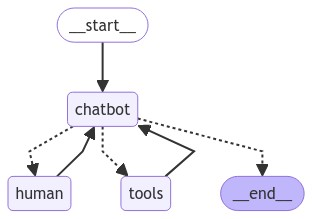

In [141]:
# visualize
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [142]:
user_input = "I need some expert guidance for creating a vlog. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for creating a vlog. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_I2HFAGoGRt5QdjtwB7B8pwAz)
 Call ID: call_I2HFAGoGRt5QdjtwB7B8pwAz
  Args:
    request: I need expert guidance for creating a vlog.


In [143]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

In [144]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out PewDiePie's Youtube channel for inspiration on how to start a vlog."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef47ced-7355-6bce-8002-9ca90e18a545'}}

In [145]:
# Verify the response has been added
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for creating a vlog. Could you request assistance for me?', id='bf1c2b75-9864-45c5-ba49-7a9d587c0276'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_I2HFAGoGRt5QdjtwB7B8pwAz', 'function': {'arguments': '{"request":"I need expert guidance for creating a vlog."}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 213, 'total_tokens': 237}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-22979aa4-2240-4736-a54d-c49f0161bece-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance for creating a vlog.'}, 'id': 'call_I2HFAGoGRt5QdjtwB7B8pwAz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 213, 'output_tokens': 24, 'total_tokens': 237}),
 ToolMessage(content="We, the experts are here to help! We'd recommend you check out Pew

In [146]:
# Next, resume the graph by invoking it with None as the inputs.
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out PewDiePie's Youtube channel for inspiration on how to start a vlog. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I have requested expert assistance for you regarding creating a vlog. In the meantime, you can check out PewDiePie's Youtube channel for inspiration on how to start a vlog.


## Part 7: Time Travel¶
what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

In [147]:
# Like code from before
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool, retriever_tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[search_tool, retriever_tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

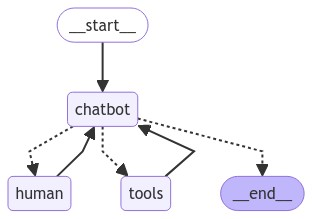

In [148]:
# Visualize
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [181]:
config = {"configurable": {"thread_id": "4"}}
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "What is the most in demand job in San Diego. Could you do some research on it for me?",
            ),
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the most in demand job in San Diego. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_r2QxgDUgY7C3uIqWcLETNemJ)
 Call ID: call_r2QxgDUgY7C3uIqWcLETNemJ
  Args:
    query: most in demand job in San Diego
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://grabjobs.co/resources/career-resources/job-search/most-in-demand-jobs-in-san-diego/", "content": "20. Transcriptionist. Scope of work: A great role for entry-level job seekers and recent graduates, transcriptionists use listening and writing skills to transcribe audio/visual files to print--best of all, these jobs are almost always remote, flexible, and well paid. And in San Diego, they are also in high demand."}, {"url": "https://www.zippia.com/advi

In [182]:
events = graph.stream(
    {
        "messages": [
            ("user", "Where are good surf spots in San Diego?"),
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Where are good surf spots in San Diego?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_LWhFGWq3X9GIDsuYs1OL6jFY)
 Call ID: call_LWhFGWq3X9GIDsuYs1OL6jFY
  Args:
    query: best surf spots in San Diego
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://gosurfingsandiego.com/best-surf-spots-in-san-diego/", "content": "Rating: #4. Skill Level: Intermediate. Another one of the best San Diego surf spots, Sunset Cliffs is a true gem of South County. This is a beautiful stretch of coastline with unmatched sunsets! On the other hand, Sunset Cliffs also has multiple high quality breaks lining this section of coastline."}, {"url": "https://thesurfatlas.com/surfing-in-the-usa/surfing-in-san-diego/", "content": "Surfing in San Diego is some of the best in t

Now that we've had the agent take a couple steps, we can replay the full state history to see everything that occurred.

In [187]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
-------------------------------------------------

In [184]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '4', 'thread_ts': '1ef47dea-30b2-6168-8001-99243526120b'}}


Notice that the checkpoint's config (to_replay.config) contains a thread_ts timestamp. Providing this thread_ts value tells LangGraph's checkpointer to load the state from that moment in time. Let's try it below:

In [185]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://grabjobs.co/resources/career-resources/job-search/most-in-demand-jobs-in-san-diego/", "content": "20. Transcriptionist. Scope of work: A great role for entry-level job seekers and recent graduates, transcriptionists use listening and writing skills to transcribe audio/visual files to print--best of all, these jobs are almost always remote, flexible, and well paid. And in San Diego, they are also in high demand."}, {"url": "https://www.zippia.com/answers/what-are-the-most-in-demand-jobs-in-san-diego-ca/", "content": "Turns out the most in demand job in San Diego is registered nurse with 3,730 current open positions. It's not a software engineer or data scientist to our surprise. How we determined the most in demand jobs in San Diego. Using the Zippia database of several million active job postings, we were able to identify the job titles with the most ..."